In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Feature importance challenge.

The data is available as two attached CSV files:

takehome_user_engagement.csv
takehome_users.csv

The data has the following two tables:
1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

● name: the user's name

● object_id: the user's id

● email: email address

● creation_source: how their account was created. This takes on one
of 5 values:

○ PERSONAL_PROJECTS: invited to join another user's personal workspace

○ GUEST_INVITE: invited to an organization as a guest (limited permissions)

○ ORG_INVITE: invited to an organization (as a full member)

○ SIGNUP: signed up via the website

○ SIGNUP_GOOGLE_AUTH: signed up using Google

Authentication (using a Google email account for their login
id)

● creation_time: when they created their account

● last_session_creation_time: unix timestamp of last login

● opted_in_to_mailing_list: whether they have opted into receiving
marketing emails

● enabled_for_marketing_drip: whether they are on the regular
marketing email drip

● org_id: the organization (group of users) they belong to

● invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

# Solution.

**The following preprocessing steps were completed:**

For the users dataset with data on login time stamps on 12,000 users who signed up for the product in the last two years:

1. Perform floor operation on all the timestamps to consider just the dates and convert them to Unix time.

2. Sort and remove duplicated days for each user. 

3. Groupby on user id with a rolling window of 3, as we are considering 3 logins minimum on three separate days.

4. Calculate the difference in days between the oldest and latest login in each window.

5. Find the user ids with the above-calculated difference of no more than 7 days to satisfy the condition: "adopted user" as a user who has logged into the product on three separate days in at least one seven day period.

6. Create a data frame with the adopted user ids as an index and add the column named 'adopted' filled with 1.

For the user_engagement and the dataset with adopted user ids merge with user_engagement on the left and perform a left join to keep all the user ids in the merged data frame. 

**Merged dataset preprocessing:**

- invited_by_user_id column had over 46% of data points missing, so it was excluded from consideration for now, as it probably would require fairly sophisticated missing values imputing not to distort the conclusions.

- last_session_creation_time column has a distribution looking like a uniform distribution with a peak at the most recent recorded times. Imputing with a media value would not make sense, as with over 25% of data points missing this type of imputing would significantly distort the last_session_creation_time distribution. The forward fill strategy was used.

- object_id, name, email, invited_by_user_id (as discussed above) were removed from feature importance consideration.

- The dataset was standardized.

**Feature importance using Logistic regression in statsmodels**

- Logistic regression was fitted on the dataset.

Choosing |coef| > 0.19 an p-values < 0.05, the top 4 features in deciding whether a user is adopted or not are:

1. creation source - all categories

2. last_session_creation_time

3. creation_time

4. org_id

**Feature importance using Random forest classifier**

- sklearn RandomForestClassifier() with max_depth = 3 was fitted on the dataset.

Top 4 features with importance were identified as follows:

1. last_session_creation_time (0.756720)

2. creation_time (0.141540)

3. org_id (0.076767)

4. creation_source_PERSONAL_PROJECTS (0.014935)

**Conclusions:**

Both approaches agree on the top 4 features in predicting whether a user is adopted or not. However, it is worth noting that invited_by_user_id column was removed from consideration. last_session_creation_time which came up in the top 2 features was 25% forward filled and therefore its importance has to be assessed more carefully.

# User engagement dataset

In [2]:
# Load user engagement dataset
user_eng = pd.read_csv('takehome_user_engagement.csv', 
                       parse_dates=['time_stamp'])

In [3]:
user_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# Perform preprocessing to get ids for adopted users 

In [4]:
# perform floor on all the time stamps to consider just the dates and convert to unix time
user_eng['time_stamp'] = \
    user_eng['time_stamp'].dt.floor('d').astype(np.int64)

# sort and remove duplicated days for each user 
user_eng = \
    user_eng.sort_values(['user_id', 'time_stamp']).drop_duplicates()

# groupby on user id with rolling window of 3, 3 logins minimum on three separate days
user_eng_window3 = \
    user_eng.groupby('user_id')['time_stamp'].rolling(window=3)

# calculate difference in days between the oldest and latest login in each window
user_eng_login_diff_days = \
    pd.to_timedelta((user_eng_window3.max()- user_eng_window3.min())).dt.days

# find the user ids with the above calculated difference no more than 7 days
user_eng_final = \
    user_eng_login_diff_days[user_eng_login_diff_days <= 7].index.get_level_values('user_id').unique()

In [5]:
# create a dataframe with the above user ids as index and add the column named 'adopted' filled with 1
user_eng_final_df = pd.DataFrame(index = user_eng_final)
user_eng_final_df['adopted'] = 1

In [6]:
user_eng_final_df.head()

,adopted
user_id,
2,1
10,1
20,1
33,1
42,1


In [7]:
# code for a more relaxed condition: at least three logins in any given week
'''
user_eng['week'] = user_eng['time_stamp'].dt.week
user_eng = user_eng.groupby(['week','user_id'])['time_stamp'].count()
user_eng = user_eng.reset_index(name='login_count')
user_eng_adopted = user_eng[user_eng['login_count'] >= 3]
'''

"\nuser_eng['week'] = user_eng['time_stamp'].dt.week\nuser_eng = user_eng.groupby(['week','user_id'])['time_stamp'].count()\nuser_eng = user_eng.reset_index(name='login_count')\nuser_eng_adopted = user_eng[user_eng['login_count'] >= 3]\n"

# Users dataset

In [8]:
# Load users dataset
users = pd.read_csv('takehome_users.csv', 
                    encoding='latin-1')

In [9]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


# Merged dataset.

In [10]:
users_combined = users.merge(user_eng_final_df, 
                             left_on='object_id', 
                             right_on='user_id', 
                             how='left')
users_combined['adopted'].fillna(0, inplace=True)

In [11]:
users_combined.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [12]:
users_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.1+ MB


# Fill NaN values of the last_session_creation_time with forward fill

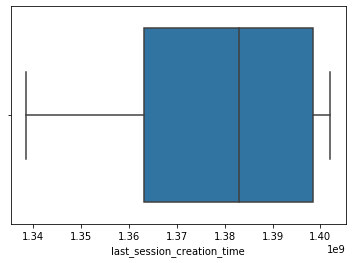

In [13]:
# Distribution before filling NaN values
_ = sns.boxplot(users_combined['last_session_creation_time'])  
plt.show()

In [14]:
users_combined['last_session_creation_time'].fillna(method = 'ffill',
                                                   inplace = True)

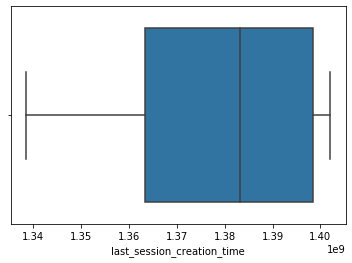

In [15]:
# Distribution after filling NaN values
_ = sns.boxplot(users_combined['last_session_creation_time'])  
plt.show()

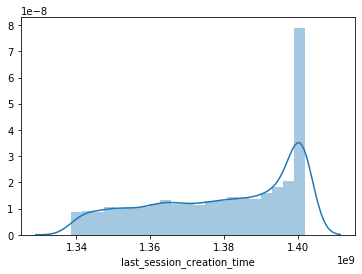

In [16]:
# Historgram of the last session creation times
_ = sns.distplot(users_combined['last_session_creation_time'])  
plt.show()

# Drop colmns: object_id, name, email, invited_by_user from consideration.

In [17]:
users_combined.drop(['object_id', 'name', 'email', 'invited_by_user_id'],
                    axis = 1,
                    inplace = True)

# Preprocessing before feature importance modelling.

**Convert creation time column to unix time.**

In [18]:
users_combined['creation_time'] = pd.to_datetime(users_combined['creation_time'])
users_combined['creation_time'] = users_combined['creation_time'].astype(np.int64)/(1*10**9)

**Get dummy variables for creation_source column.**

In [19]:
users_combined = pd.get_dummies(users_combined, 
                                prefix = ['creation_source'], 
                                columns = ['creation_source'])

**Apply standard scaler on the numeric columns.**

In [20]:
scaler = StandardScaler()
users_combined[['creation_time', 
                'last_session_creation_time', 
                'org_id']] = \
    scaler.fit_transform(users_combined[['creation_time', 
                                         'last_session_creation_time', 
                                         'org_id']])

In [21]:
users_combined.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.290656,0.960074,1,0,-1.055082,0.0,1,0,0,0,0
1,0.561296,0.862743,0,0,-1.135694,1.0,0,1,0,0,0
2,-0.547419,-0.801131,0,0,-0.386006,0.0,0,1,0,0,0
3,-0.259511,-0.520841,0,0,-1.135694,0.0,1,0,0,0,0
4,-0.831499,-1.051216,0,0,0.412050,0.0,1,0,0,0,0


**Separate features and target a variable - whether a user is adopted or not.**

In [22]:
features = users_combined.drop(['adopted'], 
                               axis = 1)
adopted = users_combined[['adopted']].values.ravel()

# Feature importance using logistic regression and statsmodels.

In [23]:
import statsmodels.api as sm

# define the model
logit = sm.Logit(adopted, features)

# fit the model
result = logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.279695
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11990
Method:                           MLE   Df Model:                            9
Date:                Wed, 11 Mar 2020   Pseudo R-squ.:                  0.3031
Time:                        09:04:52   Log-Likelihood:                -3356.3
converged:                       True   LL-Null:                       -4815.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
creation_time                         -1.1179      0.037    

**Choosing |coef| > 0.19 an p-values < 0.05, the top 4 features in deciding whether a user is adopted or not are:**

**1. creation source - all categories**

**2. last_session_creation_time**

**3. creation_time**

**4. org_id**

# Feature importance using Random Forest classifier.

In [24]:
rand_forest = RandomForestClassifier(n_jobs = -1, 
                                     max_depth = 3)

# Fit the model on the trainng data.
rand_forest.fit(features, adopted)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [25]:
def plot_feature_importances(model):
    n_features = features.shape[1]
    _ = plt.figure(figsize=(4,10))
    _ = plt.barh(np.arange(n_features), 
                 model.feature_importances_, 
                 align='center')
    _ = plt.xticks(fontsize = 14)
    _ = plt.yticks(np.arange(n_features), 
                   features.columns, 
                   fontsize = 14)
    _ = plt.xlabel('Feature importance', 
                   fontsize = 14)
    _ = plt.ylabel('Feature', fontsize = 14)
    _ = plt.ylim(-1, n_features)
    _ = plt.title('oversampled data', 
                  fontsize = 14)

    return plt

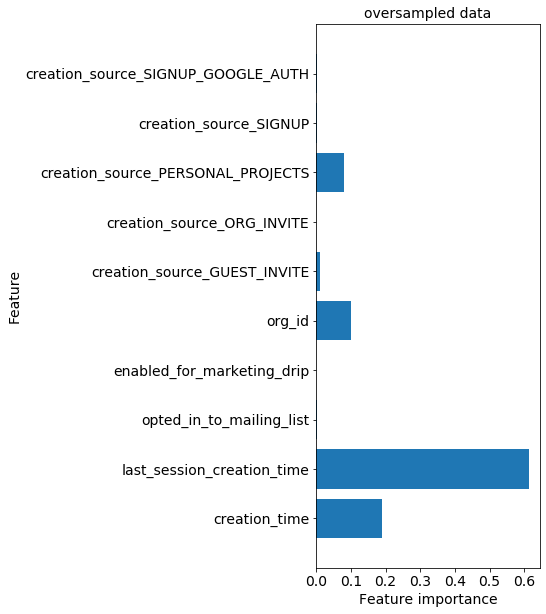

In [26]:
plot_feature_importances(rand_forest).show()

In [27]:
labels = features.columns
importances = rand_forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(features.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            labels[indices[f]], 
                            importances[indices[f]]))

 1) last_session_creation_time     0.613363
 2) creation_time                  0.189239
 3) org_id                         0.100830
 4) creation_source_PERSONAL_PROJECTS 0.078623
 5) creation_source_GUEST_INVITE   0.010750
 6) creation_source_SIGNUP         0.003384
 7) creation_source_SIGNUP_GOOGLE_AUTH 0.002198
 8) opted_in_to_mailing_list       0.001280
 9) enabled_for_marketing_drip     0.000286
10) creation_source_ORG_INVITE     0.000047
